In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from MonteCarlo import MonteCarlo
import random 
import scipy
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
from scipy import optimize
from scipy.stats import norm
from scipy.optimize import fsolve, bisect, brentq, newton

# European call

## Basic Research

### BS formula

In [3]:
def formula_price(spot, strike, vol, tau, r, phi):
    # phi = 1 -> call option, phi = -1 -> put option
    var = vol * np.sqrt(tau)
    d1 = (np.log(spot / strike) + r * tau + 0.5 * var ** 2) / var
    d2 = d1 - var

    v1 = scipy.stats.norm.cdf(phi * d1)
    v2 = scipy.stats.norm.cdf(phi * d2)

    price = phi * (spot * v1 - strike * np.exp(-r * tau) * v2)

    return price


### GBM: MonteCarlo & BS formula

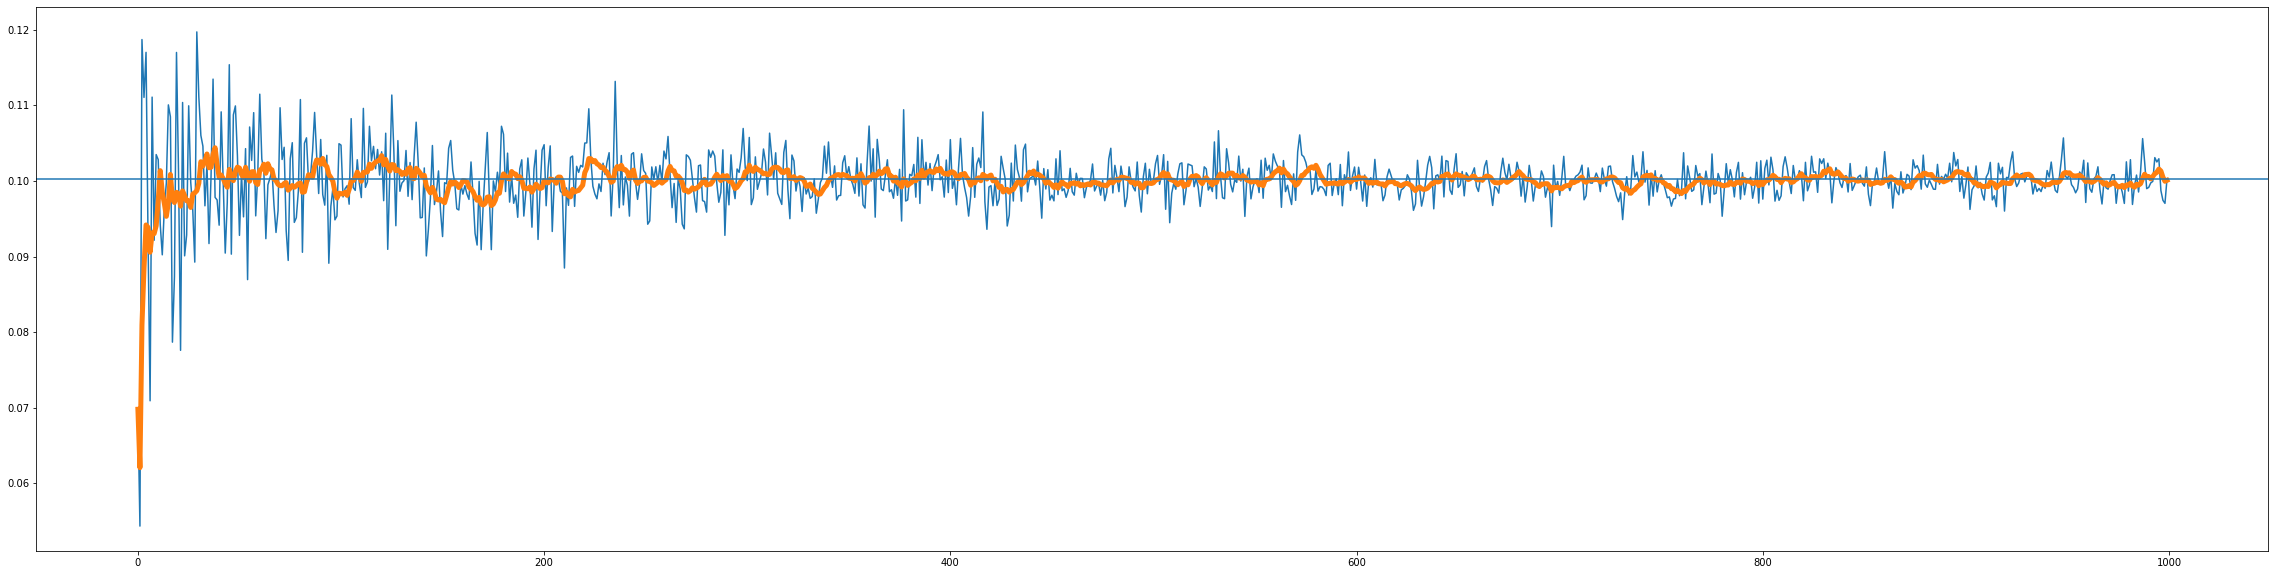

In [25]:
r = 0.05
tau = 1
spot = 1
strike = 1.1
vol = 0.3
phi = 1 
# use closed-from formula 
fm_price = formula_price(spot, strike, vol, tau, r, phi)
# use Monte Carlo
MC = MonteCarlo(model='GBM', S0=spot, K=strike, T=tau, r=r, q=0, v=vol)
mc_prices = []
for n_paths in np.arange(10, 10000+10, 10):
    mc_prices.append(MC.pricer(n_paths, 1, optionType='c', European=True, antiVar=True))
S_paths = MC.get_path('S')

plt.figure(figsize=(40,10))
plt.plot(mc_prices)
plt.plot(pd.Series(mc_prices).rolling(10, min_periods=1).mean(), linewidth=5)
plt.axhline(fm_price)

In [26]:
pd.Series(np.maximum(S_paths-strike, 0).reshape(-1,)).describe()

count    10000.000000
mean         0.105408
std          0.203216
min          0.000000
25%          0.000000
50%          0.000000
75%          0.130196
max          1.814176
dtype: float64

(array([6550.,  293.,  262.,  298.,  259.,  232.,  196.,  198.,  194.,
         152.]),
 array([0.  , 0.03, 0.06, 0.09, 0.12, 0.15, 0.18, 0.21, 0.24, 0.27, 0.3 ]),
 <BarContainer object of 10 artists>)

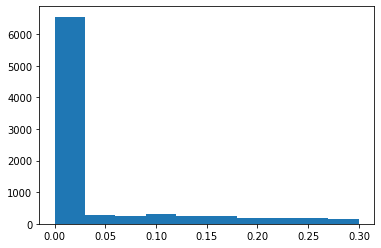

In [27]:
plt.hist(np.maximum(S_paths - strike, 0), bins=10, range=(0,0.3))

### Heston: MonteCarlo  (fix $n_{steps}$, change $n_{paths}$)

100%|██████████| 491/491 [02:38<00:00,  3.10it/s]


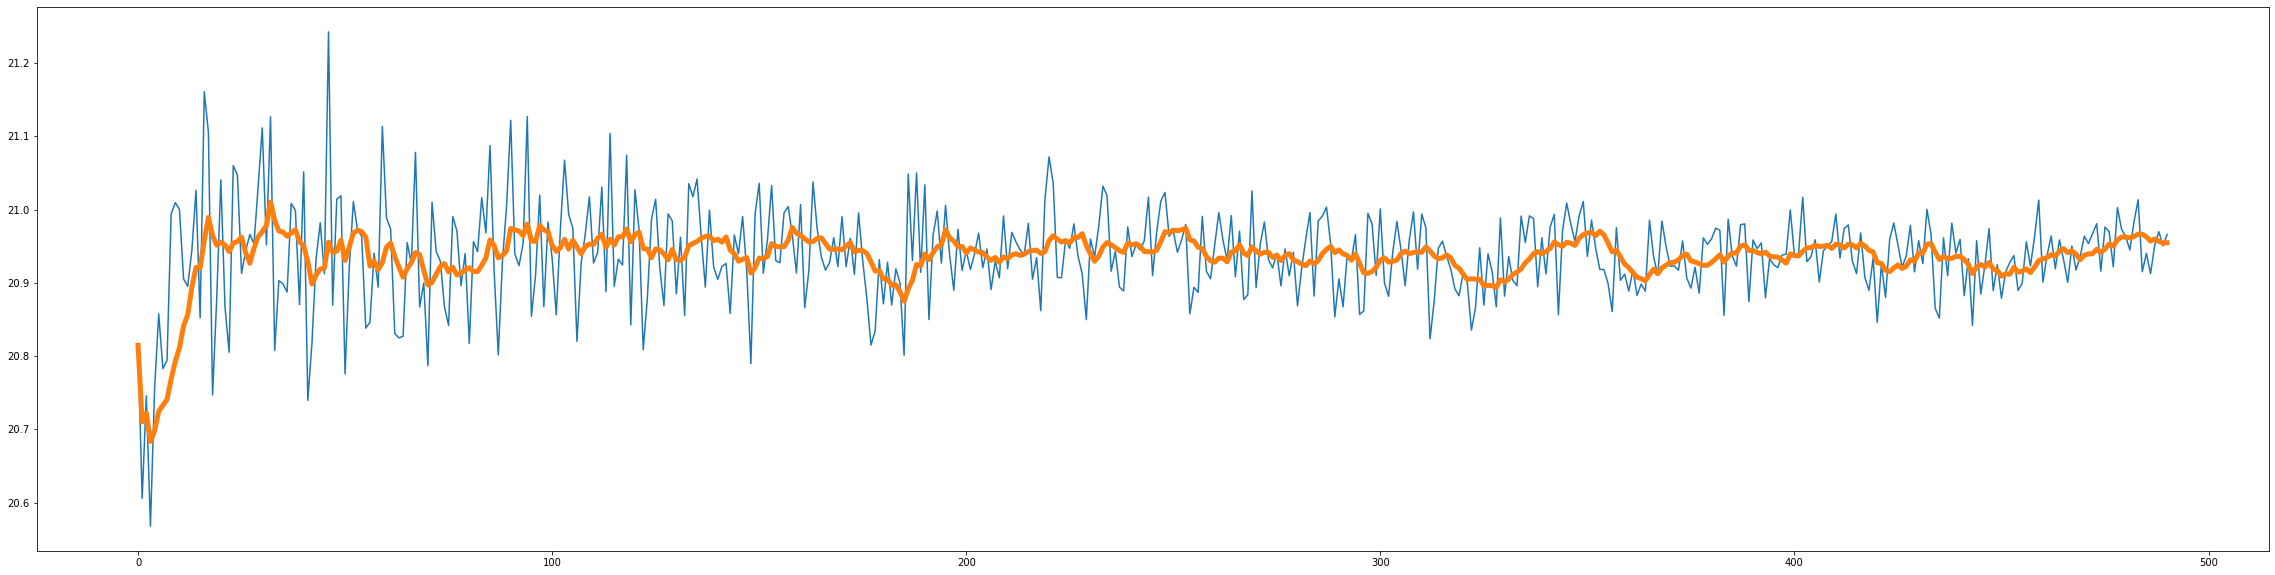

In [80]:
r = 0.01
q = 0.02 
S0 = 100 
tau = 1
vol0 = 0.04
kappa = 4
theta = 0.25
gamma = 1
rho = -0.5

K = 90
# use closed-from formula 
# fm_price = formula_price(spot, strike, vol, tau, r, phi)
# use Monte Carlo
MC = MonteCarlo(model='Heston', S0=S0, K=K, T=tau, r=r, q=q, v0=vol0, theta=theta, kappa=kappa, gamma=gamma, rho=rho)
mc_prices = []
for n_paths in tqdm(np.arange(10000, 500000+1000, 1000)):
    mc_prices.append(MC.pricer(n_paths, 10, optionType='c', European=True, antiVar=True))
vol_paths = MC.get_path('v')
S_paths = MC.get_path('S')

plt.figure(figsize=(40,10))
plt.plot(mc_prices)
plt.plot(pd.Series(mc_prices).rolling(10, min_periods=1).mean(), linewidth=5)
# plt.axhline(fm_price)


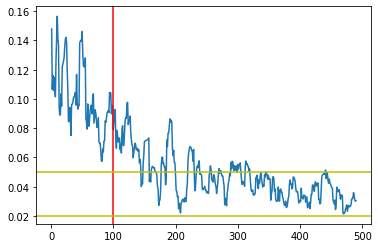

In [83]:
pd.Series(mc_prices).rolling(10, min_periods=1).std().plot()
plt.axvline(100, color='r')
plt.axhline(0.05, color='y')
plt.axhline(0.02, color='y')

In [84]:
r = 0.01
q = 0.02 
S0 = 100 
tau = 1
vol0 = 0.04
kappa = 4
theta = 0.25
gamma = 1
rho = -0.5

# reference price https://financepress.com/2019/02/15/heston-model-reference-prices/
# P K = 80: 7.958878113256768285213263077598987193482161301733  
# C K = 80: 26.774758743998854221382195325726949201687074848341
# P K = 90: 12.017966707346304987709573290236471654992071308187
# C K = 90: 20.933349000596710388139445766564068085476194042256

K = 80
MC = MonteCarlo(model='Heston', S0=S0, K=K, T=tau, r=r, q=q, v0=vol0, theta=theta, kappa=kappa, gamma=gamma, rho=rho)
option_price1 = MC.pricer(200000, 10, optionType='p', European=True, antiVar=False)
ref1 = 7.958878113256768285213263077598987193482161301733  
deviation1 = np.abs( option_price1 / ref1 - 1)

K = 80
MC = MonteCarlo(model='Heston', S0=S0, K=K, T=tau, r=r, q=q, v0=vol0, theta=theta, kappa=kappa, gamma=gamma, rho=rho)
option_price2 = MC.pricer(200000, 10, optionType='c', European=True, antiVar=False)
ref2 = 26.774758743998854221382195325726949201687074848341
deviation2 = np.abs( option_price2 / ref2 - 1)

K = 90
MC = MonteCarlo(model='Heston', S0=S0, K=K, T=tau, r=r, q=q, v0=vol0, theta=theta, kappa=kappa, gamma=gamma, rho=rho)
option_price3 = MC.pricer(200000, 10, optionType='p', European=True, antiVar=False)
ref3 = 12.017966707346304987709573290236471654992071308187
deviation3 = np.abs( option_price3 / ref3 - 1)

K = 90
MC = MonteCarlo(model='Heston', S0=S0, K=K, T=tau, r=r, q=q, v0=vol0, theta=theta, kappa=kappa, gamma=gamma, rho=rho)
option_price4 = MC.pricer(200000, 10, optionType='c', European=True, antiVar=False)
ref4 = 20.933349000596710388139445766564068085476194042256
deviation4 = np.abs( option_price4 / ref4 - 1)

print(option_price1, '\n', option_price2, '\n', option_price3, '\n', option_price4)
print(deviation1, '\n', deviation2, '\n', deviation3, '\n', deviation4)

7.951207277982391 
 26.748776286350058 
 12.037658622552549 
 20.99171007168892
0.0009638086128747059 
 0.0009704086560489156 
 0.0016385396702927046 
 0.0027879471693967872


(array([  1.,   1.,   0.,   3.,   5.,  12.,   7.,  21.,  33.,  54.,  59.,
         60., 100., 101., 126., 145., 146., 188., 224., 223., 226., 241.,
        268., 316., 306., 290., 295., 318., 287., 300., 304., 304., 295.,
        288., 265., 280., 269., 253., 247., 223., 206., 205., 215., 216.,
        147., 188., 167., 141., 134., 118., 126., 112.,  82.,  81.,  88.,
         59.,  60.,  47.,  59.,  44.,  38.,  38.,  38.,  47.,  32.,  28.,
         15.,  25.,  24.,  19.,  18.,  17.,   8.,  14.,   8.,   9.,   6.,
          3.,   9.,   3.,   3.,   2.,   2.,   1.,   1.,   2.,   2.,   2.,
          1.,   0.,   2.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   1.,
          1.]),
 array([0.00558527, 0.01195141, 0.01831755, 0.02468368, 0.03104982,
        0.03741596, 0.0437821 , 0.05014824, 0.05651438, 0.06288052,
        0.06924665, 0.07561279, 0.08197893, 0.08834507, 0.09471121,
        0.10107735, 0.10744349, 0.11380963, 0.12017576, 0.1265419 ,
        0.13290804, 0.13927418, 0.14564032, 0.

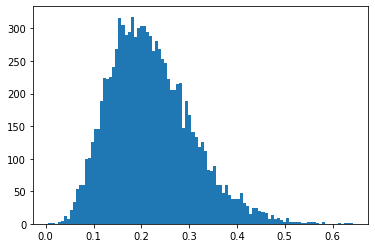

In [25]:
plt.hist(pd.DataFrame(vol_paths).iloc[:, -1], bins=100)

<Figure size 2880x1440 with 0 Axes>

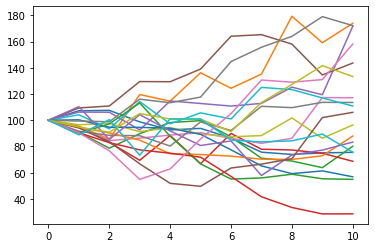

In [66]:
plt.figure(figsize=(40,20))
fig, ax = plt.subplots()
ax.plot(pd.DataFrame(S_paths.T).iloc[:, 0:20])

In [68]:
pd.Series(np.maximum(S_paths[:, -1] - K, 0)).describe()

count    100000.000000
mean         21.227849
std          31.885168
min           0.000000
25%           0.000000
50%           3.820917
75%          33.625920
max         376.865396
dtype: float64

<BarContainer object of 10 artists>

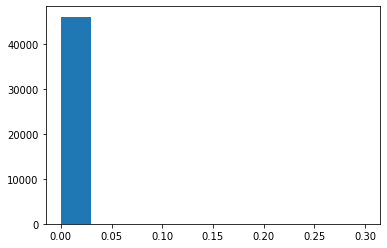

In [70]:
_, _, fig = plt.hist(pd.Series(np.maximum(S_paths[:, -1] - K, 0)), bins=10, range=(0,0.3))
fig

### Heston: MonteCarlo  (fix $n_{paths}$, change $n_{steps}$)

100%|██████████| 100/100 [01:23<00:00,  1.20it/s]


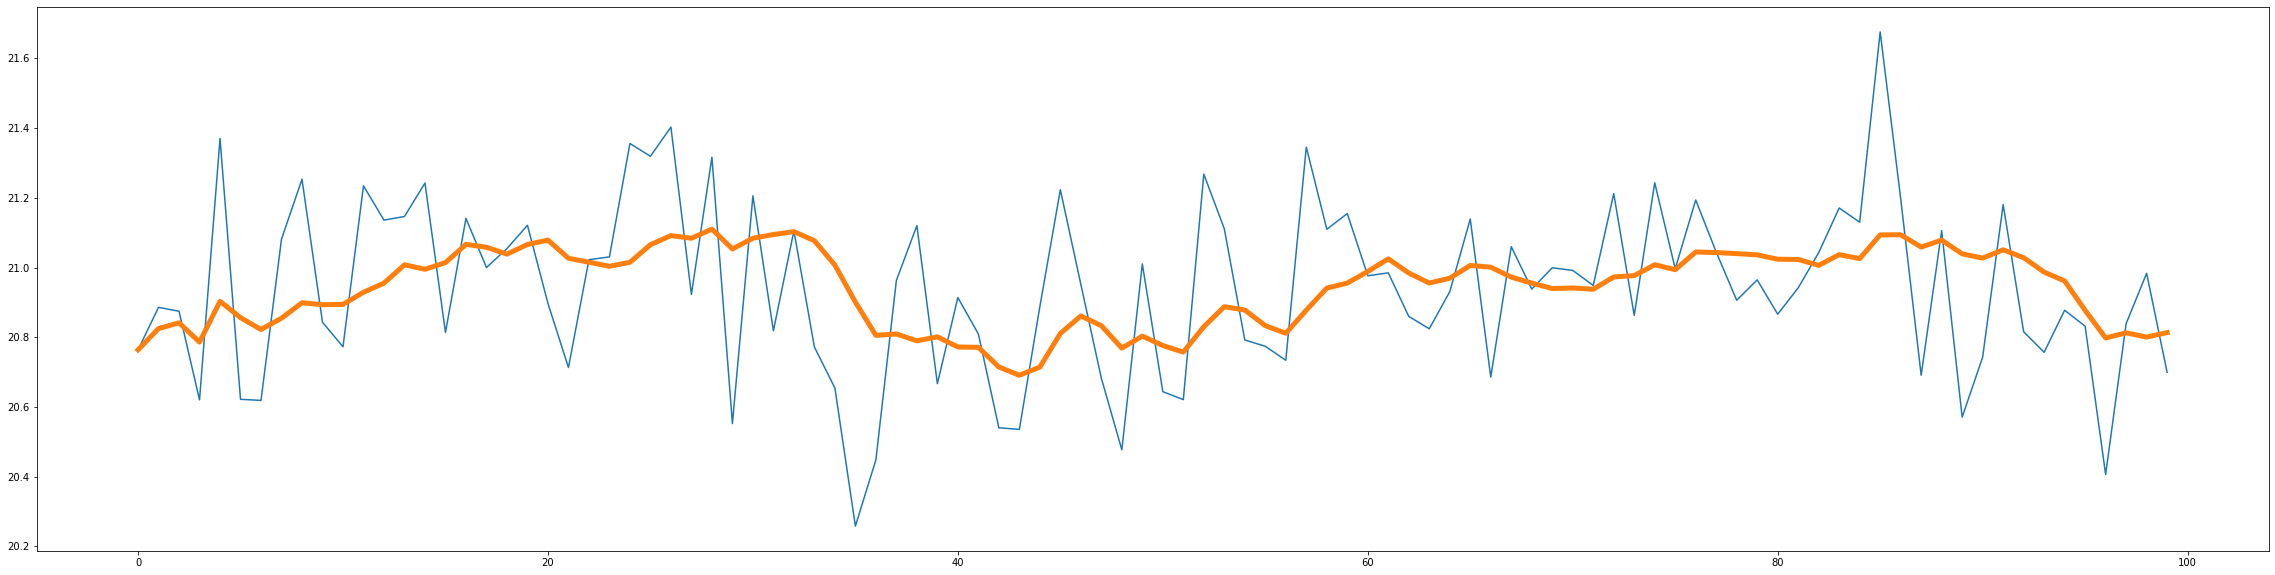

In [52]:
r = 0.01
q = 0.02 
S0 = 100 
tau = 1
vol0 = 0.04
kappa = 4
theta = 0.25
gamma = 1
rho = -0.5

K = 90
MC = MonteCarlo(model='Heston', S0=S0, K=K, T=tau, r=r, q=q, v0=vol0, theta=theta, kappa=kappa, gamma=gamma, rho=rho)
mc_prices = []
for n_steps in tqdm(np.arange(10, 1000+10, 10)):
    mc_prices.append(MC.pricer(10000, n_steps, optionType='c', European=True, antiVar=True))
vol_paths = MC.get_path('v')
S_paths = MC.get_path('S')

plt.figure(figsize=(40,10))
plt.plot(mc_prices)
plt.plot(pd.Series(mc_prices).rolling(10, min_periods=1).mean(), linewidth=5)


<AxesSubplot:>

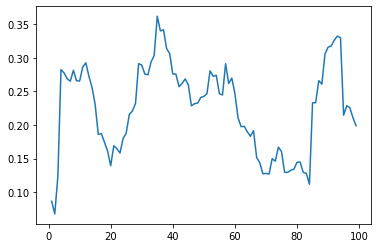

In [53]:
pd.Series(mc_prices).rolling(10, min_periods=1).std().plot()
plt.axvline(100, color='r')
plt.axhline(0.05, color='y')
plt.axhline(0.02, color='y')

In [ ]:
r = 0.01
q = 0.02 
S0 = 100 
tau = 1
vol0 = 0.04
kappa = 4
theta = 0.25
gamma = 1
rho = -0.5

# reference price https://financepress.com/2019/02/15/heston-model-reference-prices/
# P K = 80: 7.958878113256768285213263077598987193482161301733  
# C K = 80: 26.774758743998854221382195325726949201687074848341
# P K = 90: 12.017966707346304987709573290236471654992071308187
# C K = 90: 20.933349000596710388139445766564068085476194042256

K = 80
MC = MonteCarlo(model='Heston', S0=S0, K=K, T=tau, r=r, q=q, v0=vol0, theta=theta, kappa=kappa, gamma=gamma, rho=rho)
option_price1 = MC.pricer(100000, 10, optionType='p', European=True, antiVar=False)
ref1 = 7.958878113256768285213263077598987193482161301733  
deviation1 = np.abs( option_price1 / ref1 - 1)

K = 80
MC = MonteCarlo(model='Heston', S0=S0, K=K, T=tau, r=r, q=q, v0=vol0, theta=theta, kappa=kappa, gamma=gamma, rho=rho)
option_price2 = MC.pricer(100000, 10, optionType='c', European=True, antiVar=False)
ref2 = 26.774758743998854221382195325726949201687074848341
deviation2 = np.abs( option_price2 / ref2 - 1)

K = 90
MC = MonteCarlo(model='Heston', S0=S0, K=K, T=tau, r=r, q=q, v0=vol0, theta=theta, kappa=kappa, gamma=gamma, rho=rho)
option_price3 = MC.pricer(100000, 10, optionType='p', European=True, antiVar=False)
ref3 = 12.017966707346304987709573290236471654992071308187
deviation3 = np.abs( option_price3 / ref3 - 1)

K = 90
MC = MonteCarlo(model='Heston', S0=S0, K=K, T=tau, r=r, q=q, v0=vol0, theta=theta, kappa=kappa, gamma=gamma, rho=rho)
option_price4 = MC.pricer(100000, 10, optionType='c', European=True, antiVar=False)
ref4 = 20.933349000596710388139445766564068085476194042256
deviation4 = np.abs( option_price4 / ref4 - 1)

print(option_price1, '\n', option_price2, '\n', option_price3, '\n', option_price4)
print(deviation1, '\n', deviation2, '\n', deviation3, '\n', deviation4)

## Predict Option Price(GBM)

### Data generation

In [2]:
model = 'GBM' 
Type = 'European' 
option = 'call' 

cols = ['moneyness', 'tau', 'r', 'vol', 'option price']
data = []

for i in tqdm(range(20000)):
    vol = random.uniform(0.02, 0.9)
    r = random.uniform(0.03, 0.08)
    tau = random.uniform(0.3, 0.95)
    moneyness = random.uniform(0.7, 1.3)
    K = 1 / moneyness
    MC = MonteCarlo(model='GBM', S0=1, K=K, T=tau, r=r, q=0, v=vol)
    option_price = MC.pricer(10000, 1, optionType='c', European=True, antiVar=True)
    if option_price > 0.01:
        data.append([moneyness, tau, r, vol, option_price])

data = pd.DataFrame(data, columns=cols)
data.to_csv(f'data/data_{model}_{Type}_{option}.csv', index=False)



100%|██████████| 20000/20000 [00:07<00:00, 2653.21it/s]


In [3]:
data.sort_values(by='option price')

,moneyness,tau,r,vol,option price
7382,0.938322,0.721144,0.071928,0.044197,0.010014
11012,0.705443,0.929697,0.077036,0.212746,0.010040
16857,0.920313,0.340756,0.060228,0.134977,0.010049
12966,0.812368,0.744416,0.039020,0.177248,0.010097
18146,0.799167,0.451849,0.059108,0.245336,0.010110
...,...,...,...,...,...
6564,1.262859,0.936259,0.058663,0.863350,0.429261
7469,1.299868,0.862259,0.078808,0.883379,0.429557
13196,1.248336,0.876933,0.061968,0.879996,0.429703
11353,1.298465,0.925432,0.053981,0.877833,0.433147


In [4]:
data.describe()

,moneyness,tau,r,vol,option price
count,18419.000000,18419.000000,18419.000000,18419.000000,18419.000000
mean,1.019181,0.628853,0.055041,0.486820,0.180976
std,0.168446,0.186724,0.014442,0.243647,0.093704
min,0.700048,0.300006,0.030001,0.020004,0.010014
25%,0.880239,0.468096,0.042501,0.287511,0.106496
50%,1.027298,0.631834,0.055010,0.492045,0.182916
75%,1.163533,0.789684,0.067559,0.697832,0.249503
max,1.299985,0.949995,0.079999,0.899985,0.439047


### GridSearch 

In [6]:
data = pd.read_csv(f'data/data_{model}_{Type}_{option}.csv')

x = data[['moneyness', 'tau', 'r', 'vol']]
y = data['option price']

scoring = {
    'r2':'r2', 
    'MSE': make_scorer(mean_squared_error),
    'MAPE': make_scorer(mean_absolute_percentage_error),
    'MAE': make_scorer(mean_absolute_error),    
    }
param_grid = {
    'activation': ['relu'],
    'solver': ['adam'],
    'hidden_layer_sizes': 
        [(2 ** i, 2 ** i) for i in np.arange(3, 7)] 
        # + [(2 ** i, 2 ** i, 2 ** i) for i in np.arange(3, 7)]  
        # + [(2 ** i, 2 ** i, 2 ** i, 2 ** i) for i in np.arange(3, 7)]
        ,
    'max_iter': [500],
    'learning_rate_init': np.arange(0.005, 0.005+0.001, 0.001),
}
MLP = MLPRegressor(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', batch_size=1024, learning_rate_init=0.02, max_iter=500, tol=1e-10, shuffle=True, verbose=False, validation_fraction=0.1)
search = GridSearchCV(MLP, param_grid=param_grid, cv=5, scoring = scoring, refit='MAPE', return_train_score=True, verbose=4, n_jobs=3)
search.fit(x,y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END activation=relu, hidden_layer_sizes=(8, 8), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.006, test=0.006) MAPE: (train=0.066, test=0.067) MSE: (train=0.000, test=0.000) r2: (train=0.994, test=0.994) total time=   2.5s
[CV 2/5] END activation=relu, hidden_layer_sizes=(8, 8), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.006, test=0.006) MAPE: (train=0.055, test=0.058) MSE: (train=0.000, test=0.000) r2: (train=0.994, test=0.994) total time=   4.7s
[CV 3/5] END activation=relu, hidden_layer_sizes=(8, 8), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.006, test=0.006) MAPE: (train=0.069, test=0.066) MSE: (train=0.000, test=0.000) r2: (train=0.993, test=0.994) total time=   5.1s
[CV 1/5] END activation=relu, hidden_layer_sizes=(16, 16), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.006, test=0.006) MAPE: (train=0.067, test=0.067) MSE: (

/Users/lusihan/Desktop/env/TBIC/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, hidden_layer_sizes=(8, 8), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.005, test=0.005) MAPE: (train=0.067, test=0.073) MSE: (train=0.000, test=0.000) r2: (train=0.995, test=0.995) total time=   9.7s
[CV 5/5] END activation=relu, hidden_layer_sizes=(16, 16), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.005, test=0.005) MAPE: (train=0.060, test=0.064) MSE: (train=0.000, test=0.000) r2: (train=0.996, test=0.996) total time=   2.7s
[CV 4/5] END activation=relu, hidden_layer_sizes=(16, 16), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.006, test=0.006) MAPE: (train=0.074, test=0.067) MSE: (train=0.000, test=0.000) r2: (train=0.993, test=0.993) total time=   4.8s
[CV 1/5] END activation=relu, hidden_layer_sizes=(32, 32), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.004, test=0.004) MAPE: (train=0.030, test=0.031) MSE: (train=0.000, test=0.000) r2: (train=0.997, test=0.997) t

GridSearchCV(cv=5,
             estimator=MLPRegressor(batch_size=1024,
                                    hidden_layer_sizes=(8, 8, 8),
                                    learning_rate_init=0.02, max_iter=500,
                                    tol=1e-10),
             n_jobs=3,
             param_grid={'activation': ['relu'],
                         'hidden_layer_sizes': [(8, 8), (16, 16), (32, 32),
                                                (64, 64)],
                         'learning_rate_init': array([0.005]),
                         'max_iter': [500], 'solver': ['adam']},
             refit='MSE', return_train_score=True,
             scoring={'MAE': make_scorer(mean_absolute_error),
                      'MAPE': make_scorer(mean_absolute_percentage_error),
                      'MSE': make_scorer(mean_squared_error), 'r2': 'r2'},
             verbose=4)

In [7]:
search.cv_results_

{'mean_fit_time': array([5.72579975, 3.31477122, 3.94902539, 6.16613841]),
 'std_fit_time': array([2.38359621, 1.08486221, 2.43180328, 1.74373839]),
 'mean_score_time': array([0.01466942, 0.00600929, 0.01033874, 0.0074523 ]),
 'std_score_time': array([0.01168153, 0.0009166 , 0.00950482, 0.00166891]),
 'param_activation': masked_array(data=['relu', 'relu', 'relu', 'relu'],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_hidden_layer_sizes': masked_array(data=[(8, 8), (16, 16), (32, 32), (64, 64)],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_learning_rate_init': masked_array(data=[0.005, 0.005, 0.005, 0.005],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_iter': masked_array(data=[500, 500, 500, 500],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object)

In [8]:
search.best_params_

{'activation': 'relu',
 'hidden_layer_sizes': (32, 32),
 'learning_rate_init': 0.005,
 'max_iter': 500,
 'solver': 'adam'}

In [9]:
search.best_score_

5.190873677601695e-05

### Single Model

In [11]:
model = 'GBM' 
Type = 'European' 
option = 'call' 

data = pd.read_csv(f'data/data_{model}_{Type}_{option}.csv')
print(data.shape)

x = data[['moneyness', 'tau', 'r', 'vol']]
y = data['option price']

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=None, shuffle=True)

# StdScaler = StandardScaler()
# x_train = StdScaler.fit_transform(x_train)

# StdScaler = StandardScaler()
# x_test = StdScaler.fit_transform(x_test)

# hls_set = [(2 ** i, 2 ** i) for i in np.arange(3, 7)] + [(2 ** i, 2 ** i, 2 ** i) for i in np.arange(3, 7)] + [(2 ** i, 2 ** i, 2 ** i, 2 ** i) for i in np.arange(3, 7)]
hls_set = [(32,32,32), (32,32,32,32)]
for hidden_layer_sizes in hls_set:  
    MLP = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, activation='relu', solver='adam', batch_size=1024, learning_rate_init=0.005, max_iter=500, tol=1e-10, shuffle=True, verbose=False, validation_fraction=0.1)
    # MLP.fit(x_train, y_train)
    # score = MLP.score(x_test, y_test)
    # print(f'Type: {Type}, option: {option}, Model: {model}, ANN r2 = {score}')

    with open('log/log_GBM_price.txt', 'a') as f:
        # hidden layer sizes
        print(f'{hidden_layer_sizes}\n')
        # f.write(f'{hidden_layer_sizes}\n')
        # r2
        r2_score = cross_val_score(MLP, x, y, scoring='r2', cv=3)
        print(f'r2: {r2_score}\n')
        # f.write(f'r2: {r2_score}\n')
        # MSE
        mse_score = cross_val_score(MLP, x, y, scoring='neg_mean_squared_error', cv=3)
        print(f'MSE: {mse_score}\n')
        # f.write(f'MSE: {mse_score}\n')
        # MAE
        mae_score = cross_val_score(MLP, x, y, scoring='neg_mean_absolute_error', cv=3)
        print(f'MAE: {mae_score}\n')
        # f.write(f'MAE: {mae_score}\n')
        # MAPE
        mape_score = cross_val_score(MLP, x, y, scoring='neg_mean_absolute_percentage_error', cv=3)
        print(f'MAPE: {mape_score}\n\n')
        # f.write(f'MAPE: {mape_score}\n\n')
    f.close()

(18419, 5)
(32, 32, 32)

r2: [0.99761163 0.99794357 0.99727999]

MSE: [-2.47229136e-05 -3.08740627e-05 -1.50695579e-05]

MAE: [-0.00499036 -0.00417725 -0.00386093]

MAPE: [-0.03223297 -0.03414014 -0.08829693]


(32, 32, 32, 32)

r2: [0.9975407  0.9917215  0.99792615]

MSE: [-3.33332873e-05 -1.74139118e-05 -2.31623526e-05]

MAE: [-0.00380417 -0.00338314 -0.00368799]

MAPE: [-0.07509383 -0.03402982 -0.04806382]




### Training Curve

In [12]:
from utils import *
from sklearn.model_selection import ShuffleSplit

model = 'GBM' 
Type = 'European' 
option = 'call' 

data = pd.read_csv(f'data/data_{model}_{Type}_{option}.csv')
print(data.shape)

x = data[['moneyness', 'tau', 'r', 'vol']]
y = data['option price']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=None, shuffle=True)

hidden_layer_sizes = (32,32,32,32)
estimator = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, activation='relu', solver='adam', batch_size=1024, learning_rate_init=0.005, max_iter=500, tol=1e-10, shuffle=True, verbose=False, validation_fraction=0.1)
estimator.fit(x_train, y_train)

(18419, 5)


MLPRegressor(batch_size=1024, hidden_layer_sizes=(32, 32, 32, 32),
             learning_rate_init=0.005, max_iter=500, tol=1e-10)

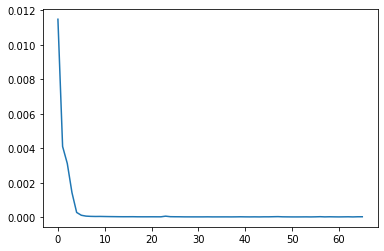

In [17]:
plt.plot(estimator.loss_curve_)

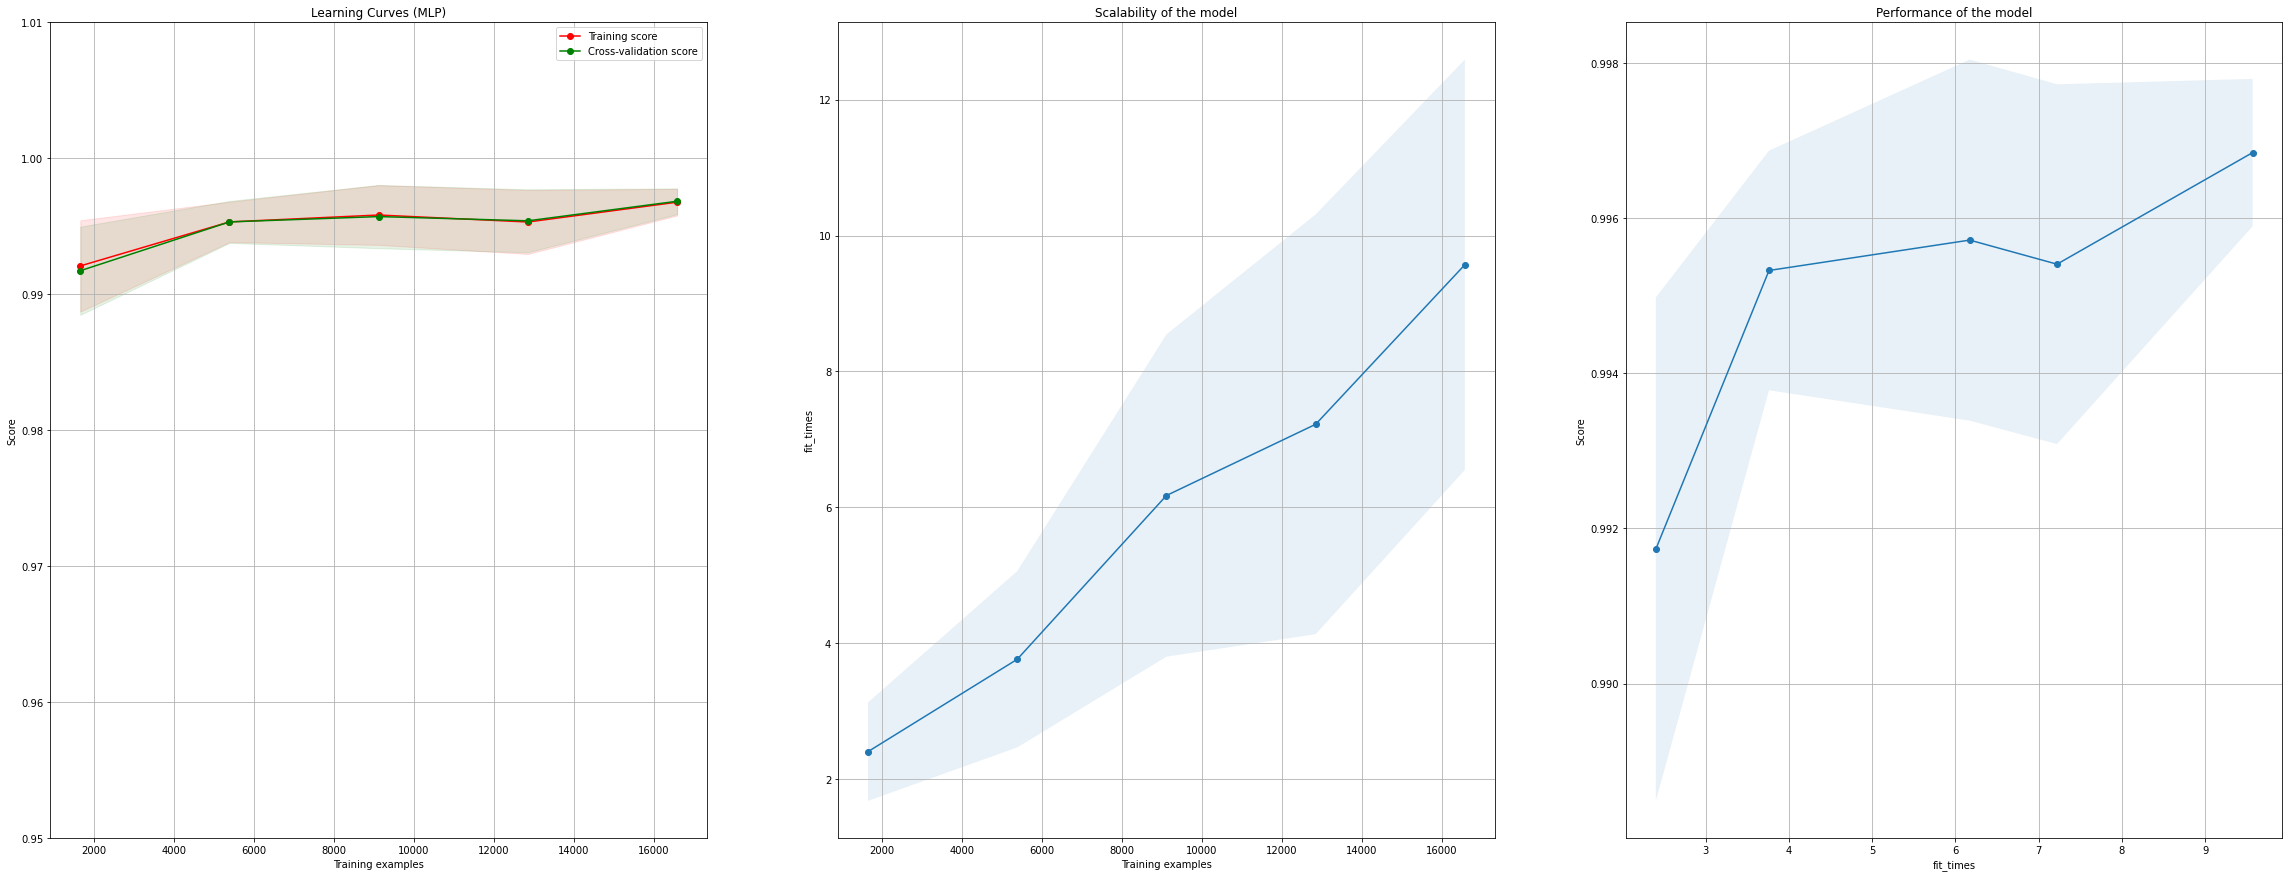

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(40, 15))

title = "Learning Curves (MLP)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.1, random_state=0)

plot_learning_curve(estimator, title, x, y, axes=axes, ylim=(0.95, 1.01), cv=cv, n_jobs=4)

plt.show()

## Predict Implied volatility(GBM)

### Data generation

/var/folders/1y/xh3w9vx97b773zbq70g3b5tm0000gn/T/ipykernel_7793/2732111434.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S0/K) + (r + 0.5 * (sigma ** 2)) * T) / (sigma * np.sqrt(T))
/var/folders/1y/xh3w9vx97b773zbq70g3b5tm0000gn/T/ipykernel_7793/2732111434.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  d2 = (np.log(S0/K) + (r - 0.5 * (sigma ** 2)) * T) / (sigma * np.sqrt(T))
/var/folders/1y/xh3w9vx97b773zbq70g3b5tm0000gn/T/ipykernel_7793/2732111434.py:50: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(figure)


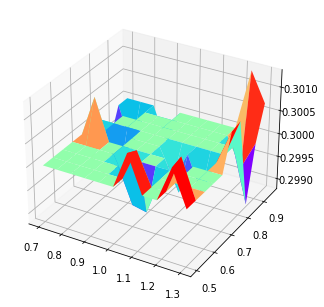

In [46]:
def IV(S0, K, r, T, V, sigma):
    N = norm.cdf
    d1 = (np.log(S0/K) + (r + 0.5 * (sigma ** 2)) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S0/K) + (r - 0.5 * (sigma ** 2)) * T) / (sigma * np.sqrt(T))
    return S0 * N(d1) - K * np.exp( - r * T ) * N(d2) - V

def IV_solver(S0, K, r, T, V):
    def IV_bisect(sigma):
        return IV(S0, K, r, T, V, sigma) 
    return bisect(IV_bisect, -10, 10)

    # def IV_fsolve(sigma):
    #     return IV(S0, K, r, T, V, sigma) 
    # return fsolve(IV_fsolve, 0.5)

    # def IV_newton(sigma):
    #     return IV(S0, K, r, T, V, sigma) 
    # return newton(IV_newton, 0.5)

    # def IV_brentq(sigma):
    #     return IV(S0, K, r, T, V, sigma) 
    # return brentq(IV_brentq, a=0, b=1.1)

vol = 0.3
r = 0.05

def cal_Z(X, Y):
    Z = np.zeros(shape=X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            x, y = X[i,j], Y[i,j]
            K = 1 / x
            tau = y
            MC = MonteCarlo(model='GBM', S0=1, K=K, T=tau, r=r, q=0, v=vol)
            option_price = MC.pricer(1000000, 1, optionType='c', European=True, antiVar=True)
            iv = IV_solver(S0=1, K=K, T=tau, r=r, V=option_price)
            if (np.abs( iv / 0.3 - 1 )) < 0.002:
                Z[i, j] = 0.3
            else:
                Z[i, j] = iv

    return Z

x = np.arange(0.7, 1.3, 0.06)
y = np.arange(0.5, 1.0, 0.05)
X, Y = np.meshgrid(x,y)
Z = cal_Z(X, Y)

figure = plt.figure()
ax = Axes3D(figure)
ax.plot_surface(X, Y, Z, cmap='rainbow')   

In [2]:
def IV(S0, K, r, T, V, sigma):
    N = norm.cdf
    d1 = (np.log(S0/K) + (r + 0.5 * (sigma ** 2)) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S0/K) + (r - 0.5 * (sigma ** 2)) * T) / (sigma * np.sqrt(T))
    return S0 * N(d1) - K * np.exp( - r * T ) * N(d2) - V

def IV_solver(S0, K, r, T, V):
    def IV_bisect(sigma):
        return IV(S0, K, r, T, V, sigma) 
    return bisect(IV_bisect, -10, 10)

    # def IV_fsolve(sigma):
    #     return IV(S0, K, r, T, V, sigma) 
    # return fsolve(IV_fsolve, 0.5)

    # def IV_newton(sigma):
    #     return IV(S0, K, r, T, V, sigma) 
    # return newton(IV_newton, 0.5)

    # def IV_brentq(sigma):
    #     return IV(S0, K, r, T, V, sigma) 
    # return brentq(IV_brentq, a=0, b=1.1)

model = 'GBM' 
Type = 'European' 
option = 'call' 


price_data = pd.read_csv(f'data/data_{model}_{Type}_{option}.csv')

# [ 0            1      2    3      4            ]
# ['moneyness', 'tau', 'r', 'vol', 'option price']

cols1 = ['moneyness', 'tau', 'r', 'value', 'implied volatility']
data1 = []
cols2 = ['moneyness', 'tau', 'r', 'time value', 'implied volatility']
data2 = []
for i in tqdm(range(price_data.shape[0])):
    x = price_data.iloc[i]
    vol = x[3]
    r = x[2]
    tau = x[1]
    moneyness = x[0]
    K = 1 / moneyness
    MC = MonteCarlo(model='GBM', S0=1, K=K, T=tau, r=r, q=0, v=vol)
    option_price = MC.pricer(100000, 1, optionType='c', European=True, antiVar=True)
    if option_price > 0.01:
        iv = IV_solver(S0=1, K=K, r=r, T=tau, V=option_price)
        intrinsic_value = np.maximum(1 - K * np.exp(- r * tau), 0)
        time_value = option_price - intrinsic_value
        if time_value < 1e-7:
            continue
        tv = np.log(time_value / K)
        if iv > 0.05:
            data1.append([moneyness, tau, r, np.log(option_price / K), iv])
            data2.append([moneyness, tau, r, tv, iv])

data1 = pd.DataFrame(data1, columns=cols1)
data2 = pd.DataFrame(data2, columns=cols2)
data1.to_csv(f'data/IV_{model}_{Type}_{option}.csv', index=False)
data2.to_csv(f'data/IV_{model}_{Type}_{option}_tv.csv', index=False)


  0%|          | 0/18419 [00:00<?, ?it/s]/var/folders/1y/xh3w9vx97b773zbq70g3b5tm0000gn/T/ipykernel_8154/313158031.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S0/K) + (r + 0.5 * (sigma ** 2)) * T) / (sigma * np.sqrt(T))
/var/folders/1y/xh3w9vx97b773zbq70g3b5tm0000gn/T/ipykernel_8154/313158031.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  d2 = (np.log(S0/K) + (r - 0.5 * (sigma ** 2)) * T) / (sigma * np.sqrt(T))
100%|██████████| 18419/18419 [05:41<00:00, 53.90it/s]


### Single model

#### The effect on prediction from value and time value

In [3]:
model = 'GBM' 
Type = 'European' 
option = 'call' 

data = pd.read_csv(f'data/IV_{model}_{Type}_{option}.csv')
print(data.shape)

x = data[['moneyness', 'tau', 'r', 'value']]
y = data['implied volatility']

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=None, shuffle=True)

# StdScaler = StandardScaler()
# x_train = StdScaler.fit_transform(x_train)

# StdScaler = StandardScaler()
# x_test = StdScaler.fit_transform(x_test)

# hls_set = [(2 ** i, 2 ** i) for i in np.arange(3, 7)] + [(2 ** i, 2 ** i, 2 ** i) for i in np.arange(3, 7)] + [(2 ** i, 2 ** i, 2 ** i, 2 ** i) for i in np.arange(3, 7)]
hls_set = [(32,32,32), (32,32,32,32)]
solver = 'adam'
activation = 'relu'

for hidden_layer_sizes in hls_set:  
    MLP = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver=solver, batch_size=1024, learning_rate_init=0.01, max_iter=500, tol=1e-10, shuffle=True, verbose=False, validation_fraction=0.1)
    # MLP.fit(x_train, y_train)
    # score = MLP.score(x_test, y_test)
    # print(f'Type: {Type}, option: {option}, Model: {model}, ANN r2 = {score}')

    with open('log/log_GBM_vol.txt', 'a') as f:
        print(f'{hidden_layer_sizes}\n')
        # f.write(f'{hidden_layer_sizes}\n')
        # r2
        r2_score = cross_val_score(MLP, x, y, scoring='r2', cv=3)
        print(f'r2: {r2_score}\n')
        f.write(f'r2: {r2_score}\n')
        # MSE
        mse_score = cross_val_score(MLP, x, y, scoring='neg_mean_squared_error', cv=3)
        print(f'MSE: {mse_score}\n')
        # f.write(f'MSE: {mse_score}\n')
        # MAE
        mae_score = cross_val_score(MLP, x, y, scoring='neg_mean_absolute_error', cv=3)
        print(f'MAE: {mae_score}\n')
        # f.write(f'MAE: {mae_score}\n')
        # MAPE
        mape_score = cross_val_score(MLP, x, y, scoring='neg_mean_absolute_percentage_error', cv=3)
        print(f'MAPE: {mape_score}\n\n')
        # f.write(f'MAPE: {mape_score}\n\n')
    f.close()

(17968, 5)
(32, 32, 32)

r2: [0.99190875 0.99193219 0.98738324]

MSE: [-0.00080525 -0.00096483 -0.00131481]

MAE: [-0.02027135 -0.02471636 -0.02145499]

MAPE: [-0.11149068 -0.09759321 -0.08320396]


(32, 32, 32, 32)

r2: [0.99133242 0.91721454 0.98557815]

MSE: [-0.00132068 -0.00083922 -0.00211182]

MAE: [-0.02307453 -0.02376007 -0.03098857]

MAPE: [-0.06987825 -0.09782034 -0.07593299]




In [4]:
model = 'GBM' 
Type = 'European' 
option = 'call' 

data = pd.read_csv(f'data/IV_{model}_{Type}_{option}_tv.csv')
print(data.shape)

x = data[['moneyness', 'tau', 'r', 'time value']]
y = data['implied volatility']

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=None, shuffle=True)

# StdScaler = StandardScaler()
# x_train = StdScaler.fit_transform(x_train)

# StdScaler = StandardScaler()
# x_test = StdScaler.fit_transform(x_test)

# hls_set = [(2 ** i, 2 ** i) for i in np.arange(3, 7)] + [(2 ** i, 2 ** i, 2 ** i) for i in np.arange(3, 7)] + [(2 ** i, 2 ** i, 2 ** i, 2 ** i) for i in np.arange(3, 7)]
hls_set = [(32,32,32), (32,32,32,32)]
solver = 'adam'
activation = 'relu'

for hidden_layer_sizes in hls_set:  
    MLP = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver=solver, batch_size=1024, learning_rate_init=0.01, max_iter=500, tol=1e-10, shuffle=True, verbose=False, validation_fraction=0.1)
    # MLP.fit(x_train, y_train)
    # score = MLP.score(x_test, y_test)
    # print(f'Type: {Type}, option: {option}, Model: {model}, ANN r2 = {score}')

    with open('log/log_GBM_vol.txt', 'a') as f:
        print(f'{hidden_layer_sizes}\n')
        # f.write(f'{hidden_layer_sizes}\n')
        # r2
        r2_score = cross_val_score(MLP, x, y, scoring='r2', cv=3)
        print(f'r2: {r2_score}\n')
        f.write(f'r2: {r2_score}\n')
        # MSE
        mse_score = cross_val_score(MLP, x, y, scoring='neg_mean_squared_error', cv=3)
        print(f'MSE: {mse_score}\n')
        # f.write(f'MSE: {mse_score}\n')
        # MAE
        mae_score = cross_val_score(MLP, x, y, scoring='neg_mean_absolute_error', cv=3)
        print(f'MAE: {mae_score}\n')
        # f.write(f'MAE: {mae_score}\n')
        # MAPE
        mape_score = cross_val_score(MLP, x, y, scoring='neg_mean_absolute_percentage_error', cv=3)
        print(f'MAPE: {mape_score}\n\n')
        # f.write(f'MAPE: {mape_score}\n\n')
    f.close()

(17968, 5)
(32, 32, 32)

r2: [0.99846072 0.99788362 0.9941413 ]

MSE: [-0.00022789 -0.0006328  -0.00016906]

MAE: [-0.01165511 -0.0111563  -0.00826905]

MAPE: [-0.04039225 -0.0329933  -0.02357518]


(32, 32, 32, 32)

r2: [0.99824914 0.99365614 0.99585537]

MSE: [-9.46903566e-05 -7.12024369e-03 -1.05643814e-04]

MAE: [-0.01824138 -0.02376139 -0.00692055]

MAPE: [-0.05058941 -0.02630338 -0.06976313]




## Predict Option Price(Heston)

### Data generation

In [10]:
model = 'Heston' 
Type = 'European' 
option = 'call' 

cols = ['moneyness', 'tau', 'r', 'vol0', 'theta', 'kappa', 'gamma', 'rho', 'option price']
data = []
for i in tqdm(range(20000)):
    r = random.uniform(0.0, 0.1)
    tau = random.uniform(0.1, 1.4)
    moneyness = random.uniform(0.6, 1.4)
    K = 1 / moneyness
    vol0 = random.uniform(0.05, 0.5)
    theta = random.uniform(0, 0.5)
    kappa = random.uniform(0, 2)
    gamma = random.uniform(0, 0.5)
    rho = random.uniform(-0.95, 0)
    MC = MonteCarlo(model='Heston', S0=1, K=1/moneyness, T=tau, r=r, q=0, v0=vol0, theta=theta, kappa=kappa, gamma=gamma, rho=rho)
    option_price = MC.pricer(200000, 10, optionType='c', European=True, antiVar=True)
    if option_price > 0.01:
        data.append([moneyness, tau, r, vol0, theta, kappa, gamma, rho, option_price])

data = pd.DataFrame(data, columns=cols)
data.to_csv(f'data/data_{model}_{Type}_{option}.csv', index=False)


100%|██████████| 20000/20000 [1:06:39<00:00,  5.00it/s]


In [5]:
model = 'Heston' 
Type = 'European' 
option = 'call' 

data = pd.read_csv(f'data/data_{model}_{Type}_{option}.csv')
data.describe()

,moneyness,tau,r,vol0,theta,kappa,gamma,rho,option price
count,9538.000000,9538.000000,9538.000000,9538.000000,9538.000000,9538.000000,9538.000000,9538.000000,9538.000000
mean,1.011811,0.766692,0.049893,0.280323,0.252680,1.009864,0.251577,-0.471868,0.192498
std,0.225154,0.368301,0.028972,0.128518,0.143673,0.576987,0.145435,0.273088,0.105564
min,0.600038,0.100124,0.000002,0.050060,0.000057,0.000133,0.000011,-0.949831,0.010048
25%,0.820013,0.452933,0.024651,0.171914,0.129138,0.515209,0.125360,-0.705057,0.102984
50%,1.012189,0.768657,0.049926,0.281253,0.254113,1.015188,0.250565,-0.471352,0.191486
75%,1.204936,1.085123,0.074929,0.391615,0.375836,1.507374,0.378487,-0.233506,0.278285
max,1.399991,1.399981,0.099983,0.499864,0.499966,1.999944,0.499947,-0.000372,0.471767


### GridSearch

In [ ]:
x = data[['moneyness', 'tau', 'r', 'vol0', 'theta', 'kappa', 'gamma', 'rho']]
y = data['option price']

scoring = {
    'r2':'r2', 
    'MSE': make_scorer(mean_squared_error),
    'MAPE': make_scorer(mean_absolute_percentage_error),
    'MAE': make_scorer(mean_absolute_error),    
    }
param_grid = {
    'activation': ['relu'],
    'solver': ['adam'],
    'hidden_layer_sizes': 
        [(2 ** i, 2 ** i) for i in np.arange(3, 7)] + 
        [(2 ** i, 2 ** i, 2 ** i) for i in np.arange(3, 7)] + 
        [(2 ** i, 2 ** i, 2 ** i, 2 ** i) for i in np.arange(3, 7)],
    'max_iter': [500],
    'learning_rate_init': np.arange(0.005, 0.005+0.001, 0.001),
}
MLP = MLPRegressor(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', batch_size=1024, learning_rate_init=0.02, max_iter=500, tol=1e-10, shuffle=True, verbose=False, validation_fraction=0.1)
search = GridSearchCV(MLP, param_grid=param_grid, cv=5, scoring = scoring, refit='MSE', return_train_score=True, verbose=4, n_jobs=3)
search.fit(x,y)

### Single model

In [6]:
model = 'Heston' 
Type = 'European' 
option = 'call' 

data = pd.read_csv(f'data/data_{model}_{Type}_{option}.csv')
print(data.shape)

x = data[['moneyness', 'tau', 'r', 'vol0', 'theta', 'kappa', 'gamma', 'rho']]
y = data['option price']

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=None, shuffle=True)

# StdScaler = StandardScaler()
# x_train = StdScaler.fit_transform(x_train)

# StdScaler = StandardScaler()
# x_test = StdScaler.fit_transform(x_test)

# hls_set = [(2 ** i, 2 ** i) for i in np.arange(3, 7)] + [(2 ** i, 2 ** i, 2 ** i) for i in np.arange(3, 7)] + [(2 ** i, 2 ** i, 2 ** i, 2 ** i) for i in np.arange(3, 7)]
hls_set = [(32,32,32), (32,32,32,32)]
for hidden_layer_sizes in hls_set:  
    MLP = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, activation='relu', solver='adam', batch_size=1024, learning_rate_init=0.005, max_iter=500, tol=1e-10, shuffle=True, verbose=False, validation_fraction=0.1)
    # MLP.fit(x_train, y_train)
    # score = MLP.score(x_test, y_test)
    # print(f'Type: {Type}, option: {option}, Model: {model}, ANN r2 = {score}')

    with open('log/log_Heston_price.txt', 'a') as f:
        # hidden layer sizes
        print(f'{hidden_layer_sizes}\n')
        # f.write(f'{hidden_layer_sizes}\n')
        # r2
        r2_score = cross_val_score(MLP, x, y, scoring='r2', cv=3)
        print(f'r2: {r2_score}\n')
        # f.write(f'r2: {r2_score}\n')
        # MSE
        mse_score = cross_val_score(MLP, x, y, scoring='neg_mean_squared_error', cv=3)
        print(f'MSE: {mse_score}\n')
        # f.write(f'MSE: {mse_score}\n')
        # MAE
        mae_score = cross_val_score(MLP, x, y, scoring='neg_mean_absolute_error', cv=3)
        print(f'MAE: {mae_score}\n')
        # f.write(f'MAE: {mae_score}\n')
        # MAPE
        mape_score = cross_val_score(MLP, x, y, scoring='neg_mean_absolute_percentage_error', cv=3)
        print(f'MAPE: {mape_score}\n\n')
        # f.write(f'MAPE: {mape_score}\n\n')

(9538, 9)
(32, 32, 32)

r2: [0.99513531 0.99247847 0.99649546]

MSE: [-3.17454438e-05 -1.37092238e-04 -3.73785049e-05]

MAE: [-0.00621314 -0.00661869 -0.0050481 ]

MAPE: [-0.05495137 -0.0683305  -0.07336216]


(32, 32, 32, 32)

r2: [0.99753405 0.99159662 0.99603192]

MSE: [-9.04179897e-05 -7.44302299e-05 -3.91319662e-05]

MAE: [-0.00527707 -0.00506266 -0.00573443]

MAPE: [-0.05838468 -0.06084262 -0.04578359]




## Predict Implied volatility(Heston)

### Data generation

In [11]:
def IV(S0, K, r, T, V, sigma):
    N = norm.cdf
    d1 = (np.log(S0/K) + (r + 0.5 * (sigma ** 2)) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S0/K) + (r - 0.5 * (sigma ** 2)) * T) / (sigma * np.sqrt(T))
    return S0 * N(d1) - K * np.exp( - r * T ) * N(d2) - V

def IV_solver(S0, K, r, T, V):
    # def IV_bisect(sigma):
    #     return IV(S0, K, r, T, V, sigma) 
    # return bisect(IV_bisect, -5, 5)

    # def IV_fsolve(sigma):
    #     return IV(S0, K, r, T, V, sigma) 
    # return fsolve(IV_fsolve, 0.5)

    def IV_newton(sigma):
        return IV(S0, K, r, T, V, sigma) 
    return newton(IV_newton, 0.5)

    # def IV_brentq(sigma):
    #     return IV(S0, K, r, T, V, sigma) 
    # return brentq(IV_brentq, a=0, b=1.1)

model = 'Heston' 
Type = 'European' 
option = 'call' 

# [ 0            1      2    3       4        5        6        7      8            ]
# ['moneyness', 'tau', 'r', 'vol0', 'theta', 'kappa', 'gamma', 'rho', 'option price']

price_data = pd.read_csv(f'data/data_{model}_{Type}_{option}.csv')

cols1 = ['moneyness', 'tau', 'r', 'vol0', 'theta', 'kappa', 'gamma', 'rho', 'value', 'IV']
data1 = []
cols2 = ['moneyness', 'tau', 'r', 'vol0', 'theta', 'kappa', 'gamma', 'rho', 'time value', 'IV']
data2 = []
for i in tqdm(range(price_data.shape[0])):
    x = price_data.iloc[i]
    K = 1 / x[0]
    iv = IV_solver(S0=1, K=K, T=x[1], r=x[2], V=x[8])
    intrinsic_value = np.maximum(1 - K * np.exp(- r * tau), 0)
    time_value = x[8] - intrinsic_value
    if time_value < 1e-7:
        continue
    tv = np.log(time_value / K)
    if iv > 0.05:
        # x[8] ->(BS)  iv 
        # x[8] ->(ANN) iv_pred
        data1.append([x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], np.log(x[8] / K), iv])
        data2.append([x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], tv, iv])

data1 = pd.DataFrame(data1, columns=cols1)
data1.to_csv(f'data/IV_{model}_{Type}_{option}.csv', index=False)
data2 = pd.DataFrame(data2, columns=cols2)
data2.to_csv(f'data/IV_{model}_{Type}_{option}_tv.csv', index=False)


  0%|          | 0/19195 [00:00<?, ?it/s]/var/folders/1y/xh3w9vx97b773zbq70g3b5tm0000gn/T/ipykernel_8154/1999187165.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S0/K) + (r + 0.5 * (sigma ** 2)) * T) / (sigma * np.sqrt(T))
/var/folders/1y/xh3w9vx97b773zbq70g3b5tm0000gn/T/ipykernel_8154/1999187165.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  d2 = (np.log(S0/K) + (r - 0.5 * (sigma ** 2)) * T) / (sigma * np.sqrt(T))
100%|██████████| 19195/19195 [04:03<00:00, 78.97it/s]


### Single model

#### The effect on prediction from value and time value

In [12]:
model = 'Heston' 
Type = 'European' 
option = 'call' 

data = pd.read_csv(f'data/IV_{model}_{Type}_{option}.csv')
print(data.shape)

x = data[['moneyness', 'tau', 'r', 'vol0', 'theta', 'kappa', 'gamma', 'rho', 'value']]
y = data['IV']

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=None, shuffle=True)

# StdScaler = StandardScaler()
# x_train = StdScaler.fit_transform(x_train)

# StdScaler = StandardScaler()
# x_test = StdScaler.fit_transform(x_test)

# hls_set = [(2 ** i, 2 ** i) for i in np.arange(3, 7)] + [(2 ** i, 2 ** i, 2 ** i) for i in np.arange(3, 7)] + [(2 ** i, 2 ** i, 2 ** i, 2 ** i) for i in np.arange(3, 7)]
hls_set = [(32,32,32), (32,32,32,32)]
solver = 'adam'
activation = 'relu'

for hidden_layer_sizes in hls_set:  
    MLP = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver=solver, batch_size=1024, learning_rate_init=0.01, max_iter=500, tol=1e-10, shuffle=True, verbose=False, validation_fraction=0.1)
    # MLP.fit(x_train, y_train)
    # score = MLP.score(x_test, y_test)
    # print(f'Type: {Type}, option: {option}, Model: {model}, ANN r2 = {score}')

    with open('log/log_Heston_vol.txt', 'a') as f:
        # hidden layer sizes
        print(f'{hidden_layer_sizes}\n')
        # f.write(f'{hidden_layer_sizes}\n')
        # r2
        r2_score = cross_val_score(MLP, x, y, scoring='r2', cv=3)
        print(f'r2: {r2_score}\n')
        # f.write(f'r2: {r2_score}\n')
        # MSE
        mse_score = cross_val_score(MLP, x, y, scoring='neg_mean_squared_error', cv=3)
        print(f'MSE: {mse_score}\n')
        # f.write(f'MSE: {mse_score}\n')
        # MAE
        mae_score = cross_val_score(MLP, x, y, scoring='neg_mean_absolute_error', cv=3)
        print(f'MAE: {mae_score}\n')
        # f.write(f'MAE: {mae_score}\n')
        # MAPE
        mape_score = cross_val_score(MLP, x, y, scoring='neg_mean_absolute_percentage_error', cv=3)
        print(f'MAPE: {mape_score}\n\n')
        # f.write(f'MAPE: {mape_score}\n\n')

(19150, 10)
(32, 32, 32)

r2: [0.97869361 0.99207174 0.99166637]

MSE: [-0.00010568 -0.0001105  -0.00012328]

MAE: [-0.00861961 -0.00712622 -0.00889174]

MAPE: [-0.01798491 -0.01792286 -0.01923792]


(32, 32, 32, 32)

r2: [0.99314373 0.99475712 0.99172703]

MSE: [-1.98877207e-04 -1.47453687e-04 -7.06725348e-05]

MAE: [-0.00725801 -0.00880003 -0.01161427]

MAPE: [-0.02397262 -0.02150144 -0.01974088]




In [13]:
model = 'Heston' 
Type = 'European' 
option = 'call' 

data = pd.read_csv(f'data/IV_{model}_{Type}_{option}_tv.csv')
print(data.shape)

x = data[['moneyness', 'tau', 'r', 'vol0', 'theta', 'kappa', 'gamma', 'rho', 'time value']]
y = data['IV']

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=None, shuffle=True)

# StdScaler = StandardScaler()
# x_train = StdScaler.fit_transform(x_train)

# StdScaler = StandardScaler()
# x_test = StdScaler.fit_transform(x_test)

# hls_set = [(2 ** i, 2 ** i) for i in np.arange(3, 7)] + [(2 ** i, 2 ** i, 2 ** i) for i in np.arange(3, 7)] + [(2 ** i, 2 ** i, 2 ** i, 2 ** i) for i in np.arange(3, 7)]
hls_set = [(32,32,32), (32,32,32,32)]
solver = 'adam'
activation = 'relu'

for hidden_layer_sizes in hls_set:  
    MLP = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver=solver, batch_size=1024, learning_rate_init=0.01, max_iter=500, tol=1e-10, shuffle=True, verbose=False, validation_fraction=0.1)
    # MLP.fit(x_train, y_train)
    # score = MLP.score(x_test, y_test)
    # print(f'Type: {Type}, option: {option}, Model: {model}, ANN r2 = {score}')

    with open('log/log_Heston_vol.txt', 'a') as f:
        # hidden layer sizes
        print(f'{hidden_layer_sizes}\n')
        # f.write(f'{hidden_layer_sizes}\n')
        # r2
        r2_score = cross_val_score(MLP, x, y, scoring='r2', cv=3)
        print(f'r2: {r2_score}\n')
        # f.write(f'r2: {r2_score}\n')
        # MSE
        mse_score = cross_val_score(MLP, x, y, scoring='neg_mean_squared_error', cv=3)
        print(f'MSE: {mse_score}\n')
        # f.write(f'MSE: {mse_score}\n')
        # MAE
        mae_score = cross_val_score(MLP, x, y, scoring='neg_mean_absolute_error', cv=3)
        print(f'MAE: {mae_score}\n')
        # f.write(f'MAE: {mae_score}\n')
        # MAPE
        mape_score = cross_val_score(MLP, x, y, scoring='neg_mean_absolute_percentage_error', cv=3)
        print(f'MAPE: {mape_score}\n\n')
        # f.write(f'MAPE: {mape_score}\n\n')

(19150, 10)
(32, 32, 32)

r2: [0.97641867 0.99034461 0.98826618]

MSE: [-1.34748979e-04 -6.95984364e-04 -7.85319090e-05]

MAE: [-0.00916141 -0.00939245 -0.01021331]

MAPE: [-0.02126036 -0.02391928 -0.01564321]


(32, 32, 32, 32)

r2: [0.97638934 0.98599591 0.98203841]

MSE: [-6.98883603e-05 -2.02958581e-04 -1.33526508e-04]

MAE: [-0.00895068 -0.00791219 -0.0059758 ]

MAPE: [-0.02174311 -0.01743728 -0.01885158]




### Smile and term structure

we need to check following arbitrage free conditions: For strike $K_i$, time to maturity $\tau$, $C_{i, \tau} = C(K_i, \tau)$
$$ \left(S_{0}-K_{i} e^{-r \tau}\right)^{+}<c_{0}<S_{0} $$
$$ \frac{C_{i, \tau}-C_{i-1, \tau}}{K_{i}-K_{i-1}} \approx \frac{\partial C(K)}{\partial K}=-e^{-r T} \int_{K}^{\infty} p(s) d s \in [-1,0]$$
$$ \frac{C_{i, \tau}-C_{i-1, \tau}}{K_{i}-K_{i-1}} \leqslant \frac{\left(C_{i+1, \tau}-C_{i, \tau}\right)}{K_{i+1}-K_{i}} \Rightarrow 
\frac{\partial^{2} C(K)}{\partial K^{2}}=e^{-r T} p(K) \geq 0
$$
$$ C_{i, \tau+d\tau}-C_{i, \tau} \geq 0 \Rightarrow \frac{\partial C}{\partial \tau} \geq 0$$

#### Smile

In [15]:
def IV(S0, K, r, T, V, sigma):
    N = norm.cdf
    d1 = (np.log(S0/K) + (r + 0.5 * (sigma ** 2)) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S0/K) + (r - 0.5 * (sigma ** 2)) * T) / (sigma * np.sqrt(T))
    return S0 * N(d1) - K * np.exp( - r * T ) * N(d2) - V

def IV_solver(S0, K, r, T, V):
    # def IV_bisect(sigma):
    #     return IV(S0, K, r, T, V, sigma) 
    # return bisect(IV_bisect, 0, 1)

    # def IV_fsolve(sigma):
    #     return IV(S0, K, r, T, V, sigma) 
    # return fsolve(IV_fsolve, 0.5)

    def IV_newton(sigma):
        return IV(S0, K, r, T, V, sigma) 
    return newton(IV_newton, 0.5)

    # def IV_brentq(sigma):
    #     return IV(S0, K, r, T, V, sigma) 
    # return brentq(IV_brentq, a=0, b=1.1)

rho = -0.05
kappa = 1.5
gamma = 0.3
theta = 0.1
vol0 = 0.1
r = 0.02

def cal_Z(X, Y):
    Z = np.zeros(shape=X.shape)
    option_price = np.zeros(shape=X.shape)
    for i in tqdm(range(X.shape[0])):
        for j in range(X.shape[1]):
            x, y = X[i,j], Y[i,j]
            K = 1 / x
            tau = y
            MC = MonteCarlo(model='Heston', S0=1, K=K, T=tau, r=r, q=0, v0=vol0, theta=theta, kappa=kappa, gamma=gamma, rho=rho)
            option_price[i,j] = MC.pricer(500000, 10, optionType='c', European=True, antiVar=True)
            iv = IV_solver(S0=1, K=K, T=tau, r=r, V=option_price[i,j])
            # Z[i, j] = iv[0]
            Z[i, j] = iv
    return Z, option_price

# x = moneyness | y = tau
x = np.arange(0.7, 1.3, 0.06)
y = np.arange(0.5, 1.0, 0.05)
X, Y = np.meshgrid(x,y)
Z, option_price = cal_Z(X, Y)

100%|██████████| 10/10 [01:15<00:00,  7.53s/it]


/var/folders/1y/xh3w9vx97b773zbq70g3b5tm0000gn/T/ipykernel_7288/3470798517.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(figure)


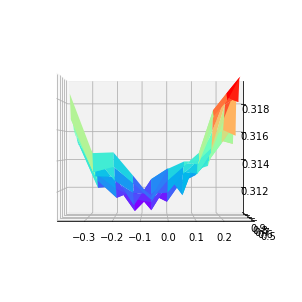

In [30]:
figure = plt.figure()
ax = Axes3D(figure)
logX = np.log(X)
ax.plot_surface(logX,Y,Z,cmap='rainbow')   
ax.view_init(0,-90)

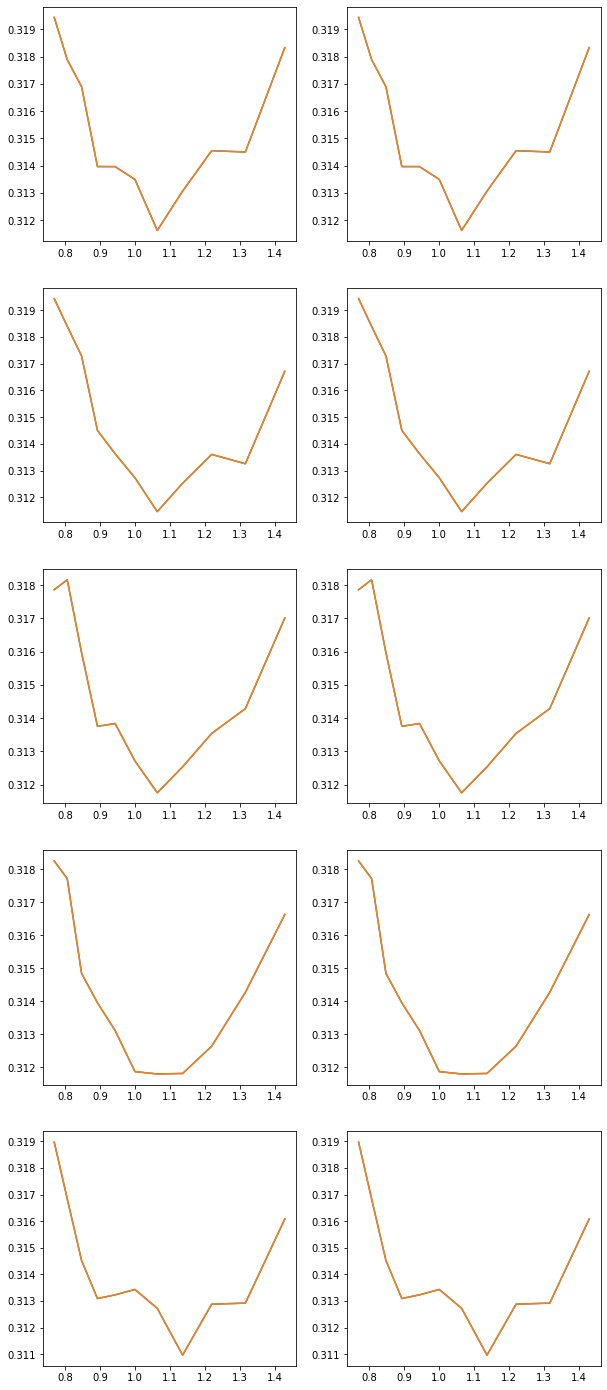

In [39]:
# fix T, volatility - K
strike = 1 / X 
fig, ax = plt.subplots(int(strike.shape[0]/2) , 2, figsize=(10,25))
for i in range(int(strike.shape[0]/2)):
    for j in range(2):
        ax[i,j].plot(strike[i, :], Z[i, :])
        ax[i,j].plot(strike[i, :], Z[i, :])

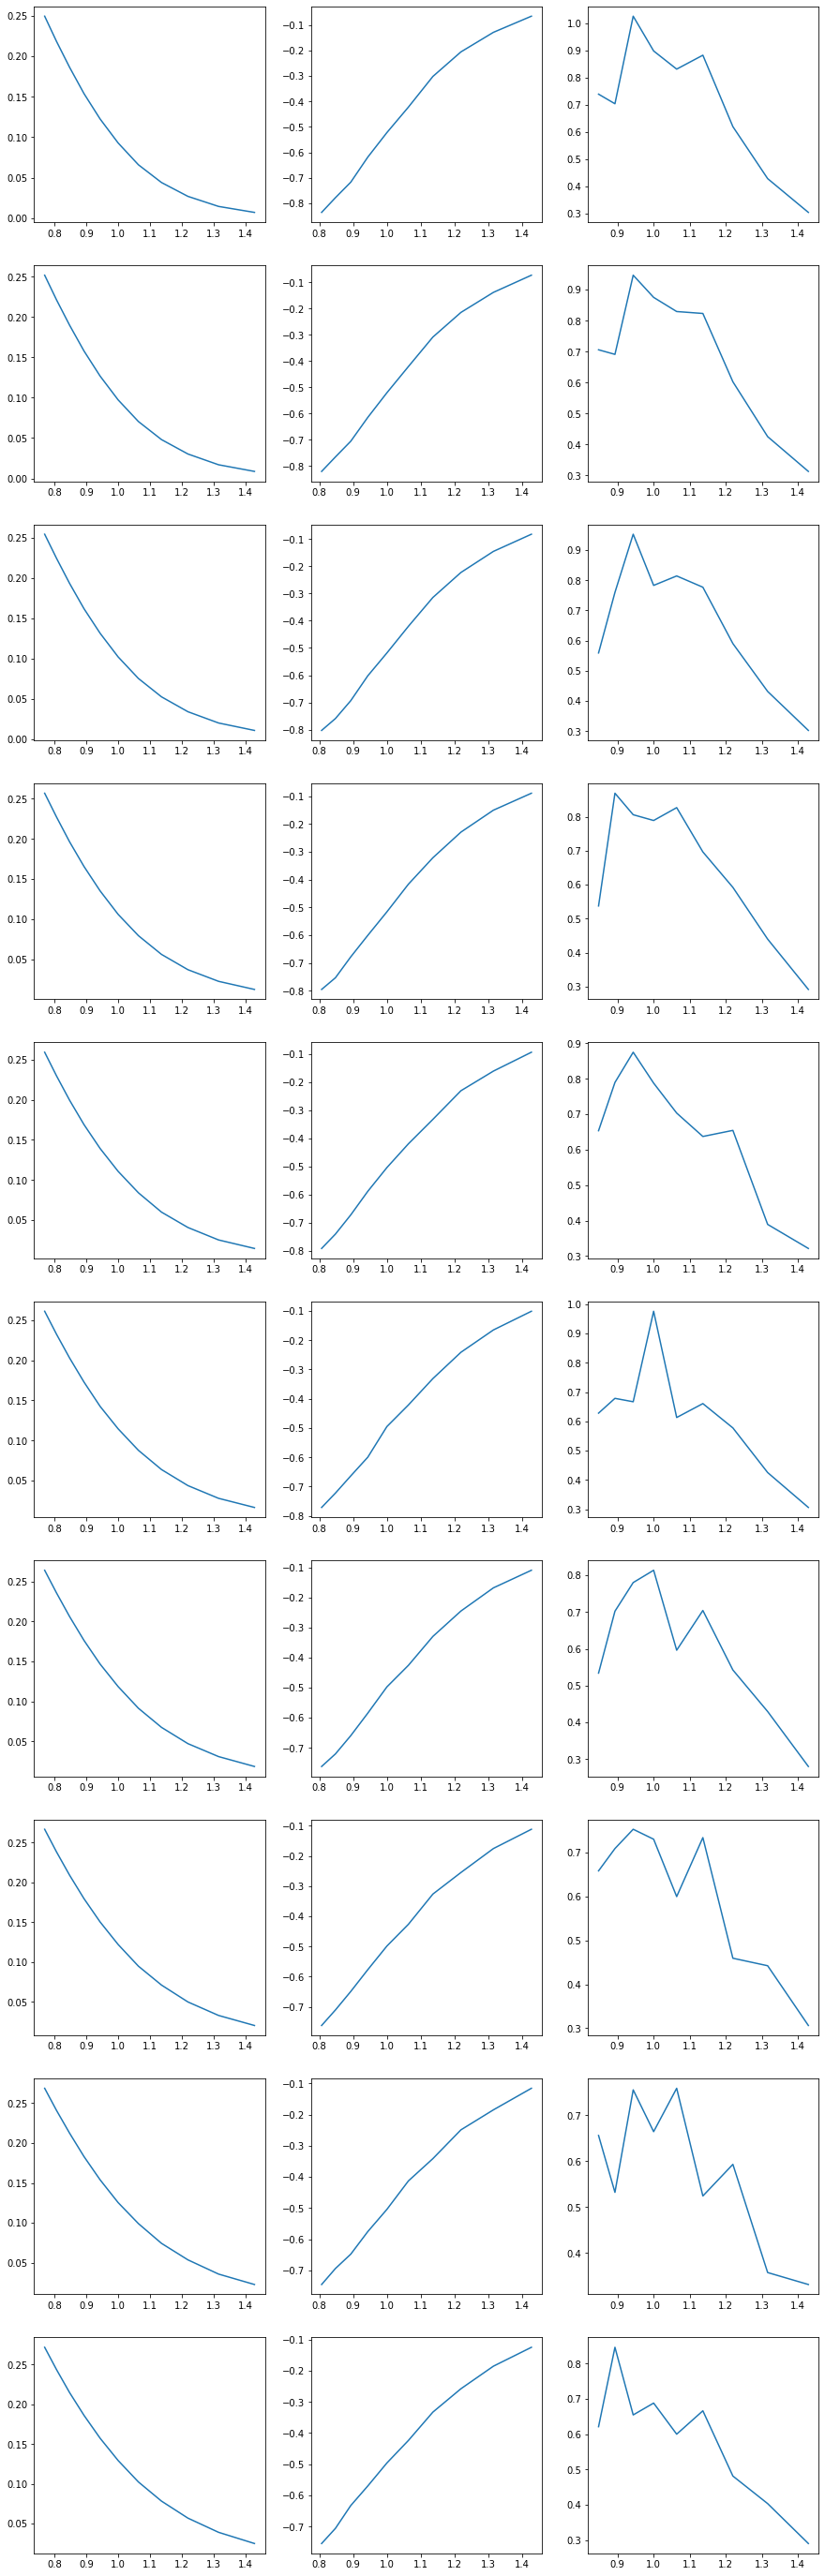

In [47]:
# fix T, option price - K
strike = 1 / X
fig, ax = plt.subplots(strike.shape[0], 3, figsize=(15,50))
for i in range(strike.shape[0]):
    ax[i,0].plot(strike[i, :], option_price[i, :])
    # tagent
    ax[i,1].plot(strike[i, :-1], (option_price[i, :-1] - option_price[i, 1:]) / (strike[i, :-1] - strike[i, 1:]))
    # convex
    tangent1 = (option_price[i, :-2] - option_price[i, 1:-1]) / (strike[i, :-2] - strike[i, 1:-1])
    tangent2 = (option_price[i, 1:-1] - option_price[i, 2:]) / (strike[i, 1:-1] - strike[i, 2:])
    ax[i,2].plot(strike[i, :-2], (tangent2 - tangent1) / (strike[i, 2:] - strike[i, :-2]))
        

#### term structure

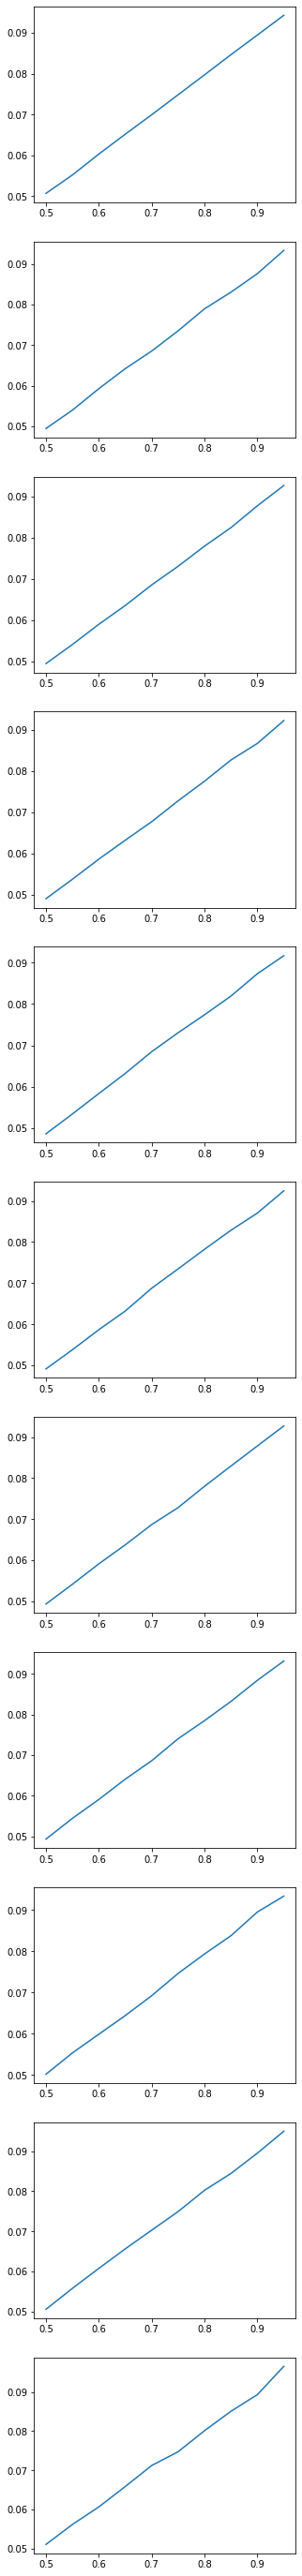

In [18]:
# fix log(moneyness), vol^2 * T non-decreasing
T = Y
fig, ax = plt.subplots(T.shape[1] , 1, figsize=(5,50))
for i in range(T.shape[1]):
    ax[i].plot(T[:, i], (Z[:, i] ** 2) * T[:, i])

#### ANN Volatility Surface
- 数据不够
- 已有数据精度不够
- 神经元数量不够

In [6]:
model = 'Heston' 
Type = 'European' 
option = 'call' 

data = pd.read_csv(f'data/IV_{model}_{Type}_{option}_tv.csv')
print(data.shape)

x = data[['moneyness', 'tau', 'r', 'vol0', 'theta', 'kappa', 'gamma', 'rho', 'time value']]
y = data['IV']

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=None, shuffle=True)

# StdScaler = StandardScaler()
# x_train = StdScaler.fit_transform(x_train)

# StdScaler = StandardScaler()
# x_test = StdScaler.fit_transform(x_test)

hidden_layer_sizes = (32, 32, 32)
solver = 'adam'
activation = 'relu'

MLP = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver=solver, batch_size=1024, learning_rate_init=0.005, max_iter=500, tol=1e-10, shuffle=True, verbose=False, validation_fraction=0.1)
MLP.fit(x, y)

# hidden layer sizes
# print(f'{hidden_layer_sizes}\n')
# r2
# r2_score = cross_val_score(MLP, x, y, scoring='r2', cv=3)
# print(f'r2: {r2_score}\n')
# MSE
# mse_score = cross_val_score(MLP, x, y, scoring='neg_mean_squared_error', cv=3)
# print(f'MSE: {mse_score}\n')
# MAE
# mae_score = cross_val_score(MLP, x, y, scoring='neg_mean_absolute_error', cv=3)
# print(f'MAE: {mae_score}\n')
# MAPE
mape_score = cross_val_score(MLP, x, y, scoring='neg_mean_absolute_percentage_error', cv=3)
print(f'MAPE: {mape_score}\n\n')


(19150, 10)
MAPE: [-0.02262787 -0.01670378 -0.02427631]




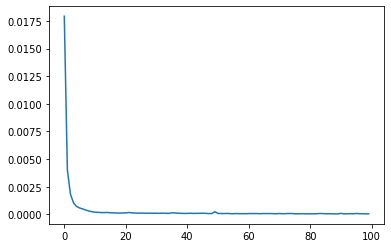

In [18]:
plt.plot(MLP.loss_curve_)

In [7]:
def IV(S0, K, r, T, V, sigma):
    N = norm.cdf
    d1 = (np.log(S0/K) + (r + 0.5 * (sigma ** 2)) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S0/K) + (r - 0.5 * (sigma ** 2)) * T) / (sigma * np.sqrt(T))
    return S0 * N(d1) - K * np.exp( - r * T ) * N(d2) - V

def IV_solver(S0, K, r, T, V):
    # def IV_bisect(sigma):
    #     return IV(S0, K, r, T, V, sigma) 
    # return bisect(IV_bisect, 0, 1)

    # def IV_fsolve(sigma):
    #     return IV(S0, K, r, T, V, sigma) 
    # return fsolve(IV_fsolve, 0.5)

    def IV_newton(sigma):
        return IV(S0, K, r, T, V, sigma) 
    return newton(IV_newton, 0.5)

    # def IV_brentq(sigma):
    #     return IV(S0, K, r, T, V, sigma) 
    # return brentq(IV_brentq, a=0, b=1.1)

rho = -0.05
kappa = 1.5
gamma = 0.3
theta = 0.1
vol0 = 0.1
r = 0.02

def cal_Z(X, Y):
    Z1 = np.zeros(shape=X.shape)
    Z2 = np.zeros(shape=X.shape)
    option_price = np.zeros(shape=X.shape)
    for i in tqdm(range(X.shape[0])):
        for j in range(X.shape[1]):
            x, y = X[i,j], Y[i,j]
            K = 1 / x
            tau = y
            MC = MonteCarlo(model='Heston', S0=1, K=K, T=tau, r=r, q=0, v0=vol0, theta=theta, kappa=kappa, gamma=gamma, rho=rho)
            option_price[i,j] = MC.pricer(500000, 10, optionType='c', European=True, antiVar=True)
            # ['moneyness', 'tau', 'r', 'vol0', 'theta', 'kappa', 'gamma', 'rho', 'time value']
            intrinsic_value = np.maximum(1 - K * np.exp(- r * tau), 0)
            time_value = option_price[i,j] - intrinsic_value
            tv = np.log(time_value / K)
            features = pd.DataFrame([[x, tau, r, vol0, theta, kappa, gamma, rho, tv]], columns=['moneyness', 'tau', 'r', 'vol0', 'theta', 'kappa', 'gamma', 'rho', 'time value'])
            iv1 = IV_solver(S0=1, K=K, T=tau, r=r, V=option_price[i,j])
            iv2 = MLP.predict(features)
            # print(features, iv1, iv2)
            Z1[i, j] = iv1
            Z2[i, j] = iv2[0]
    return Z1, Z2, option_price

# x = moneyness | y = tau
x = np.arange(0.7, 1.3, 0.06)
y = np.arange(0.5, 1.0, 0.05)
X, Y = np.meshgrid(x,y)
Z1, Z2, option_price = cal_Z(X, Y)

100%|██████████| 10/10 [01:08<00:00,  6.81s/it]


/var/folders/1y/xh3w9vx97b773zbq70g3b5tm0000gn/T/ipykernel_9007/1204822945.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax1 = Axes3D(figure1)
/var/folders/1y/xh3w9vx97b773zbq70g3b5tm0000gn/T/ipykernel_9007/1204822945.py:8: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax2 = Axes3D(figure2)
/var/folders/1y/xh3w9vx97b773zbq70g3b5tm0000gn/T/ipykernel_9007/1204822945.p

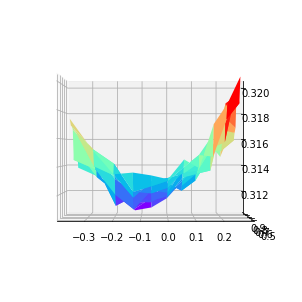

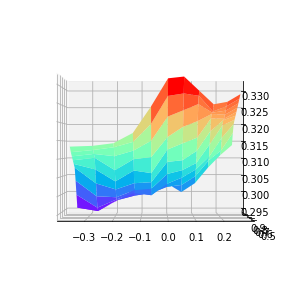

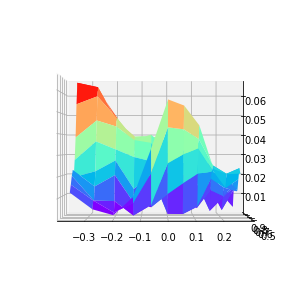

In [12]:
figure1 = plt.figure()
ax1 = Axes3D(figure1)
logX = np.log(X)
ax1.plot_surface(logX,Y,Z1,cmap='rainbow')  
ax1.view_init(0,-90)

figure2 = plt.figure()
ax2 = Axes3D(figure2)
logX = np.log(X)
ax2.plot_surface(logX,Y,Z2,cmap='rainbow')  
ax2.view_init(0,-90)

figure3 = plt.figure()
ax3 = Axes3D(figure3)
logX = np.log(X)
ax3.plot_surface(logX,Y,np.abs(Z1 / Z2 - 1),cmap='rainbow')  
ax3.view_init(0,-90)

In [11]:
pd.DataFrame(np.abs(Z1 / Z2 - 1)*100).mean()

0     3.381505
1     3.289304
2     2.823711
3     2.149974
4     2.608958
5     2.647405
6     2.777152
7     2.484514
8     1.874265
9     1.350112
10    1.466510
dtype: float64

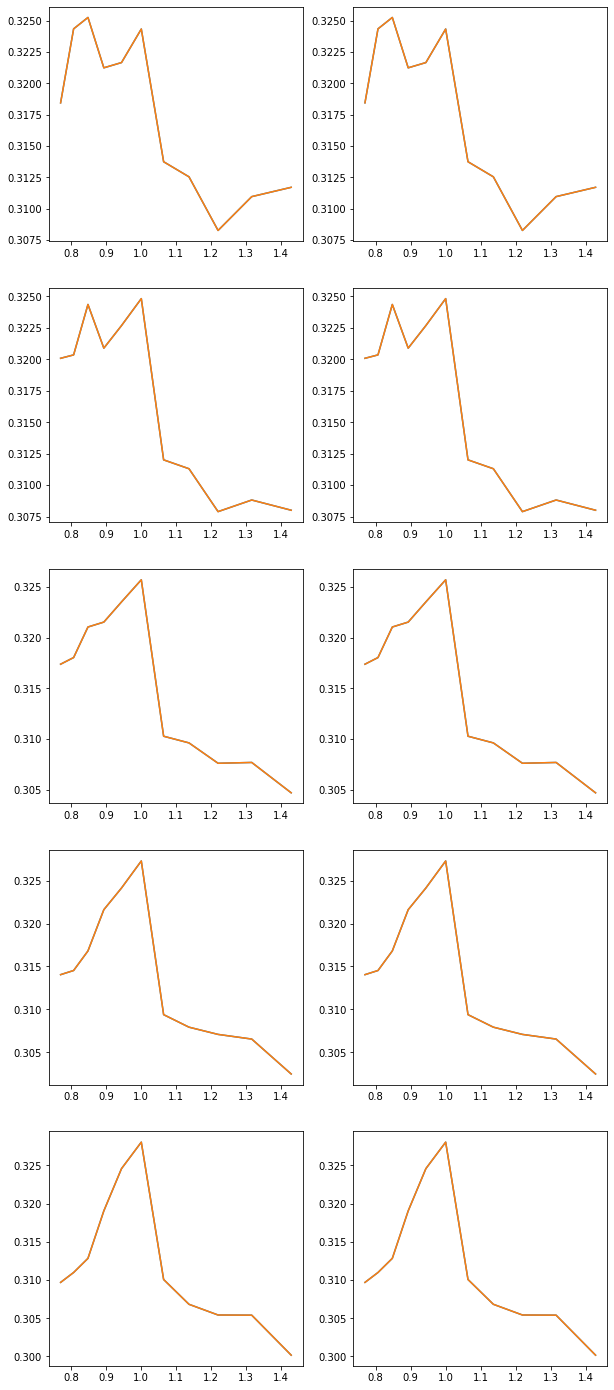

In [28]:
# fix T, volatility - K
strike = 1 / X 
fig, ax = plt.subplots(int(strike.shape[0]/2) , 2, figsize=(10,25))
for i in range(int(strike.shape[0]/2)):
    for j in range(2):
        ax[i,j].plot(strike[i, :], Z[i, :])
        ax[i,j].plot(strike[i, :], Z[i, :])